<a href="https://colab.research.google.com/github/idan424/Comp.Learning_Neuro/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [144]:
!git clone https://github.com/idan424/Comp.Learning_Neuro


fatal: destination path 'Comp.Learning_Neuro' already exists and is not an empty directory.


In [145]:
PATH = '/content/Comp.Learning_Neuro/'
_files = ['Run_200 02.trc', 'Run_300 02.trc', 
          'Run_400 02.trc', 'Run_500 02.trc']
f = _files[0]

In [146]:
def load_data(f):
    _data = pd.read_table(PATH+f, header=4, index_col=0).iloc[:,:-1]
    _data = _data.rename(columns={'Unnamed: 1':'Time'})
    _data.reset_index(inplace=True)
    labels = pd.DataFrame(np.ones(len(_data)-2)*int(f[4:7]))
    
    return _data, labels
    

def add_norm(_data):
    for n in range(1,len(_data.columns)//3+1):
        R_data = np.linalg.norm(_data[[f"X{n}",f"Y{n}",f"Z{n}"]].values,axis=1)
        _data.insert(n*4+1,f'norm{n}',R_data)
    
    return _data
    

def add_av(_data):
    v_data = _data.copy().drop(['Time','index'], axis=1).diff()
    a_data = v_data.diff()

    v_data = v_data.rename(columns={n:f"V_{n}" for n in _data.columns})
    a_data = a_data.rename(columns={n:f"A_{n}" for n in _data.columns})

    return _data.join([v_data, a_data]).dropna()


def divide_dataset(_data, label):
    N = len(_data)//10
    
    return [ _data.loc[10*n:10*(n+1)-1] for n in range(N)], label[0:N]


def segment_processing(_seg): 
    seg = _seg.drop(['Time','index'], axis=1)

    mean_data = seg.mean().rename({n:f'mean_{n}'for n in seg.columns})
    std_data = seg.std().rename({n:f'std_{n}'for n in seg.columns})
    max_data = seg.max().rename({n:f'max_{n}'for n in seg.columns})
    min_data = seg.min().rename({n:f'min_{n}'for n in seg.columns})
    median_data = seg.median().rename({n:f'median_{n}'for n in seg.columns})

    return mean_data.append([std_data,max_data,min_data,median_data])  # returns a pd.Series()


def extract_features(seg_list):
    data = pd.DataFrame([segment_processing(seg) for seg in seg_list]) 
    
    return data


def process_file(f):
    X,y = load_data(f)
    X = add_norm(X)
    X = add_av(X)
    
    segments, y = divide_dataset(X, y)
    X = extract_features(segments)

    return (X,y)  # returns a tuple

In [147]:
files = _files
Xy = [process_file(f) for f in files]
Xy = list(zip(*Xy))  # this flip the tuple axis order

X, y = pd.concat(Xy[0]), pd.concat(Xy[1])
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)


In [148]:
print(X.shape,y.shape)

(190, 2520) (190, 1)


## EDA

> # Train Test Split

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)


In order to avoid leakage, we fit our transforms (norm, feat. select.) on the training data, and then transform the data (both train and test)

In [161]:
from sklearn.feature_selection import mutual_info_classif as MI
from sklearn.feature_selection import SelectKBest as SKB 
from sklearn.preprocessing import MinMaxScaler as NRM

NUMBER_OF_FEATURES = int(X_train.shape[0]**0.5)
nrm = NRM().fit(X_train.values) # normalization function
skb = SKB(score_func=MI, k=NUMBER_OF_FEATURES).fit(X_train, y_train) # feature selector utility

# X_train and X_test are both normalized with respect to X_train to prevent leakage
X_train = pd.DataFrame(nrm.transform(X_train.values), columns=X_train.columns)
X_test = pd.DataFrame(nrm.transform(X_test.values), columns=X_test.columns)

# These are the best-K feature matrices (np.array type)
X_train_skb = skb.transform(X_train)  
X_test_skb = skb.transform(X_test)


# features and scores

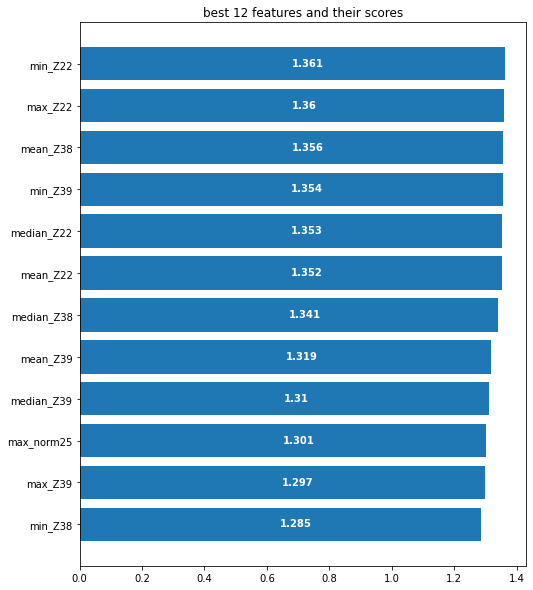

In [162]:
N_PRINT = NUMBER_OF_FEATURES
# this gets $N_PRINT score indices from high to low
ord_idx = skb.scores_.argsort()[-N_PRINT-1:-1]

fig, ax = plt.subplots()  
fig.set_size_inches([8,N_PRINT/3+6]) # modular figure size w.r.t. $N_PRINT

# these just prettify the graph
_ = ax.barh(range(N_PRINT), skb.scores_[ord_idx], 
            tick_label=X_train.columns[ord_idx])
_ = ax.set_title(f"best {N_PRINT} features and their scores")
for i, v in enumerate(skb.scores_[ord_idx]):
    ax.text(v/2, i-0.05, f'{v:.4}', color='white', fontweight='bold')


In [ ]:
# X_train_skb

In [ ]:
knn = KNeighborsClassifier(n_neighbors=12)
_ = knn.fit(X_train_skb, y_train)
_y_predicted = knn.predict(X_test_skb)
_y_predicted = pd.DataFrame(data=_y_predicted,index = y_test.index)

misclassification_rate = np.sum(y_predicted - y_test)
misclassification_rate

0    0.0
dtype: float64

In [ ]:
y_predicted = _y_predicted
y_predicted = y_predicted.join(y_test, rsuffix='_test')



0    False
dtype: bool


## _##########################################################_

In [ ]:
# X.plot()
# ax = plt.gca()
# ax.legend().remove()
# ax.figure.set_size_inches([16,200])
y_train